In [1]:
from cell_2170_model import cell_2170
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model Voltage vs SOC curve

In [2]:
# initialize cell model with terminal voltage of 3.3 V
cell_model = cell_2170(initial_voltage=3.3)

output_variables = [
    "Terminal voltage [V]",
    "Current [A]",
    # "Electrolyte concentration [mol.m-3]",
    # "Negative particle surface concentration [mol.m-3]",
    # "Positive particle surface concentration [mol.m-3]",
    "Discharge capacity [A.h]"
]

cell_model.sim_cali.plot(output_variables)

CasADi - 2023-04-21 23:46:44 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:499]


interactive(children=(FloatSlider(value=0.0, description='t', max=40.935710288301834, step=0.40935710288301835…

In [3]:
cell_model.total_capacity

4.6612044559765

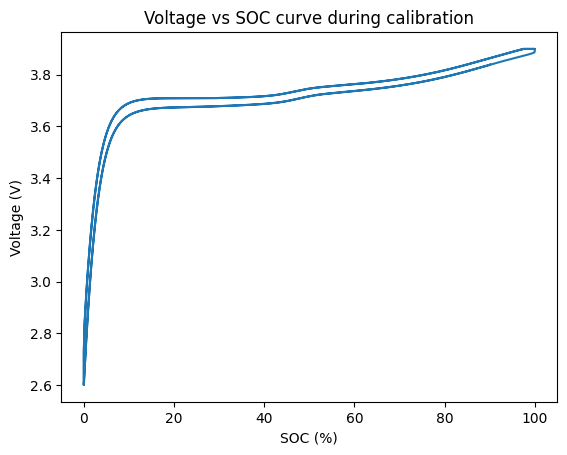

In [4]:
SOC_array = cell_model.cali_capacity_array / cell_model.total_capacity * 100

fig, ax = plt.subplots()
ax.plot(SOC_array, cell_model.cali_v_array)
ax.set_title("Voltage vs SOC curve during calibration")
ax.set_xlabel("SOC (%)")
ax.set_ylabel("Voltage (V)")
plt.show()

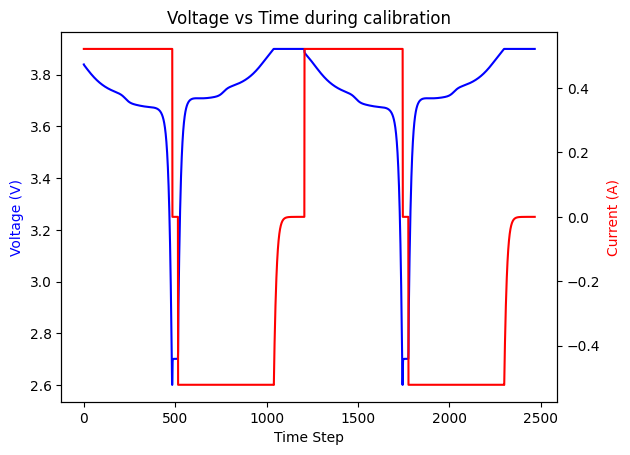

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(cell_model.cali_v_array, "b-")
ax2.plot(cell_model.cali_i_array, "r-")
ax1.set_title("Voltage vs Time during calibration")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Voltage (V)", color="b")
ax2.set_ylabel("Current (A)", color="r")
plt.show()

#### Change Y axis to Power

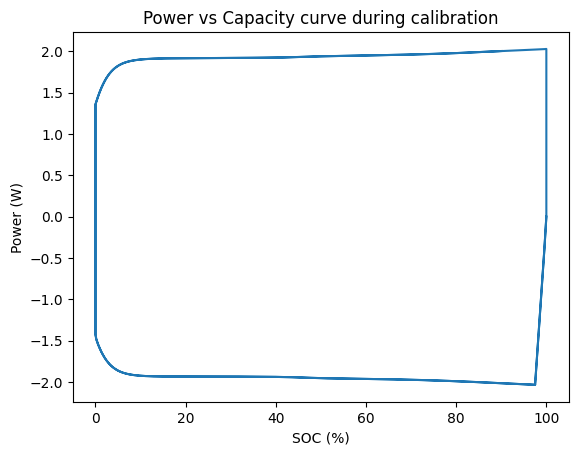

In [6]:
power_array = cell_model.cali_i_array * cell_model.cali_v_array

fig, ax = plt.subplots()
ax.plot(SOC_array, power_array)
ax.set_title("Power vs Capacity curve during calibration")
ax.set_xlabel("SOC (%)")
ax.set_ylabel("Power (W)")
plt.show()

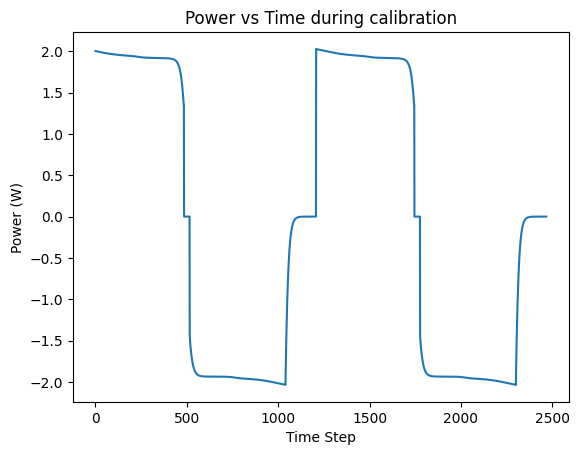

In [7]:
fig, ax = plt.subplots()
ax.plot(power_array)
ax.set_title("Power vs Time during calibration")
ax.set_xlabel("Time Step")
ax.set_ylabel("Power (W)")
plt.show()

In [8]:
cell_model.cali_capacity_array

array([4.20020266, 4.19150701, 4.18281135, ..., 4.66120446, 4.66120446,
       4.66120446])

In [9]:
cell_capacity_array = cell_model.cali_capacity_array.reshape((len(cell_model.cali_capacity_array),1))
cell_v_array = cell_model.cali_v_array.reshape((len(cell_model.cali_v_array),1))
cell_i_array = cell_model.cali_i_array.reshape((len(cell_model.cali_i_array),1))

SOC_array = cell_capacity_array / cell_model.total_capacity
SOC_array = SOC_array.reshape((len(SOC_array),1))

pandas_array = np.concatenate((cell_v_array, cell_i_array, cell_capacity_array, SOC_array), axis=1)

In [10]:
column_values = ['voltage', 'current','capacity', 'SOC']

df_cell = pd.DataFrame(data = pandas_array, 
                       columns = column_values)

In [11]:
df_cell

,voltage,current,capacity,SOC
0,3.839942,0.521739,4.200203,0.901098
1,3.838084,0.521739,4.191507,0.899233
2,3.837018,0.521739,4.182811,0.897367
3,3.836041,0.521739,4.174116,0.895502
4,3.835093,0.521739,4.165420,0.893636
...,...,...,...,...
2464,3.900000,0.000000,4.661204,1.000000
2465,3.900000,0.000000,4.661204,1.000000
2466,3.900000,0.000000,4.661204,1.000000
2467,3.900000,0.000000,4.661204,1.000000


### Assembly of cells for model 3 battery pack
4,416 pcs of 2170 cells:
- 46 cells in parallel (summing capacity) for each group
- 96 groups in series (summing voltage).

In [12]:
df_pack = df_cell

df_pack['voltage'] = df_cell.copy()['voltage'] * 96
df_pack['current'] = df_cell.copy()['current'] * 46
df_pack['capacity'] = df_cell.copy()['capacity'] * 46
df_pack['power'] = df_pack['voltage'] * df_pack['current']

df_pack

,voltage,current,capacity,SOC,power
0,368.634453,24.0,193.209322,0.901098,8847.226880
1,368.456103,24.0,192.809322,0.899233,8842.946477
2,368.353706,24.0,192.409322,0.897367,8840.488946
3,368.259974,24.0,192.009322,0.895502,8838.239371
4,368.168896,24.0,191.609322,0.893636,8836.053506
...,...,...,...,...,...
2464,374.399973,0.0,214.415405,1.000000,0.000000
2465,374.399973,0.0,214.415405,1.000000,0.000000
2466,374.399973,0.0,214.415405,1.000000,0.000000
2467,374.399973,0.0,214.415405,1.000000,0.000000


### Export 2 dataframes out of the df_pack
- df_charging: a whole charging session
- df_dis_charging: a whole dis-charging session

#### drop the dataset's section before the 1st charging session

In [13]:
df_pack.loc[df_pack.index[df_pack['power'] < 0][0]]

voltage     2.621763e+02
current    -2.400000e+01
capacity    3.350209e-12
SOC         1.562485e-14
power      -6.292231e+03
Name: 516, dtype: float64

In [14]:
df_pack_update = df_pack.drop(np.arange(df_pack.index[0], df_pack.index[df_pack['power'] < 0][0]))
df_pack_update

,voltage,current,capacity,SOC,power
516,262.176311,-24.0,3.350209e-12,1.562485e-14,-6292.231465
517,272.991145,-24.0,4.000000e-01,1.865538e-03,-6551.787477
518,278.803322,-24.0,8.000000e-01,3.731075e-03,-6691.279735
519,283.866526,-24.0,1.200000e+00,5.596613e-03,-6812.796623
520,288.542104,-24.0,1.600000e+00,7.462150e-03,-6925.010491
...,...,...,...,...,...
2464,374.399973,0.0,2.144154e+02,1.000000e+00,0.000000
2465,374.399973,0.0,2.144154e+02,1.000000e+00,0.000000
2466,374.399973,0.0,2.144154e+02,1.000000e+00,0.000000
2467,374.399973,0.0,2.144154e+02,1.000000e+00,0.000000


#### export the charging section exclusively for the 1st charging session

In [15]:
df_pack_update.loc[df_pack_update.index[df_pack_update['power'] == 0][0]]

voltage     374.399978
current       0.000000
capacity    214.412652
SOC           0.999987
power         0.000000
Name: 1177, dtype: float64

In [16]:
df_charging = df_pack_update.loc[np.arange(df_pack.index[df_pack['power'] < 0][0], df_pack_update.index[df_pack_update['power'] == 0][0])]
df_charging

,voltage,current,capacity,SOC,power
516,262.176311,-24.000000,3.350209e-12,1.562485e-14,-6292.231465
517,272.991145,-24.000000,4.000000e-01,1.865538e-03,-6551.787477
518,278.803322,-24.000000,8.000000e-01,3.731075e-03,-6691.279735
519,283.866526,-24.000000,1.200000e+00,5.596613e-03,-6812.796623
520,288.542104,-24.000000,1.600000e+00,7.462150e-03,-6925.010491
...,...,...,...,...,...
1172,374.400000,-0.000622,2.144126e+02,9.999870e-01,-0.232814
1173,374.400000,-0.000580,2.144126e+02,9.999870e-01,-0.217237
1174,374.400000,-0.000539,2.144126e+02,9.999871e-01,-0.201660
1175,374.400000,-0.000497,2.144126e+02,9.999871e-01,-0.186083


#### drop the dataset's section before the 2nd dis-charging session

In [17]:
df_pack_update.index[0]

516

In [18]:
df_pack_update = df_pack_update.drop(np.arange(df_pack_update.index[0], df_pack_update.index[df_pack_update['power'] > 0][0]))
df_pack_update

,voltage,current,capacity,SOC,power
1208,373.260700,24.0,214.412652,0.999987,8958.256808
1209,373.004676,24.0,214.012652,0.998122,8952.112225
1210,372.875331,24.0,213.612652,0.996256,8949.007940
1211,372.765467,24.0,213.212652,0.994391,8946.371202
1212,372.664605,24.0,212.812652,0.992525,8943.950527
...,...,...,...,...,...
2464,374.399973,0.0,214.415405,1.000000,0.000000
2465,374.399973,0.0,214.415405,1.000000,0.000000
2466,374.399973,0.0,214.415405,1.000000,0.000000
2467,374.399973,0.0,214.415405,1.000000,0.000000


#### export the charging section exclusively for the 2nd charging session

In [19]:
df_dis_charging = df_pack_update.loc[np.arange(df_pack_update.index[df_pack_update['power'] > 0][0], df_pack_update.index[df_pack_update['power'] == 0][0])]
df_dis_charging

,voltage,current,capacity,SOC,power
1208,373.260700,24.0,214.412652,0.999987,8958.256808
1209,373.004676,24.0,214.012652,0.998122,8952.112225
1210,372.875331,24.0,213.612652,0.996256,8949.007940
1211,372.765467,24.0,213.212652,0.994391,8946.371202
1212,372.664605,24.0,212.812652,0.992525,8943.950527
...,...,...,...,...,...
1741,267.018271,24.0,1.212652,0.005656,6408.438507
1742,261.526958,24.0,0.812652,0.003790,6276.646998
1743,255.771868,24.0,0.412652,0.001925,6138.524836
1744,249.753248,24.0,0.012652,0.000059,5994.077960


### Charging

### From df_charging, construct a model with concave equation

In [20]:
# take out the power drop after the peak of power
df_charging['pos_power'] = - df_charging['power']

max_power_index = df_charging.index[df_charging['pos_power'] == max(df_charging['pos_power'])]

df_charging_partial = df_charging.loc[np.arange(df_charging.index[0], max_power_index.item()+1)]
df_charging_partial

,voltage,current,capacity,SOC,power,pos_power
516,262.176311,-24.000000,3.350209e-12,1.562485e-14,-6292.231465,6292.231465
517,272.991145,-24.000000,4.000000e-01,1.865538e-03,-6551.787477,6551.787477
518,278.803322,-24.000000,8.000000e-01,3.731075e-03,-6691.279735,6691.279735
519,283.866526,-24.000000,1.200000e+00,5.596613e-03,-6812.796623,6812.796623
520,288.542104,-24.000000,1.600000e+00,7.462150e-03,-6925.010491,6925.010491
...,...,...,...,...,...,...
1036,374.175765,-24.000000,2.080000e+02,9.700796e-01,-8980.218370,8980.218370
1037,374.260057,-24.000000,2.084000e+02,9.719451e-01,-8982.241366,8982.241366
1038,374.345172,-24.000000,2.088000e+02,9.738106e-01,-8984.284137,8984.284137
1039,374.399040,-24.000000,2.090508e+02,9.749804e-01,-8985.576960,8985.576960


In [21]:
from scipy.optimize import curve_fit

x = df_charging_partial['SOC'].to_numpy()
y = df_charging_partial['pos_power'].to_numpy()

def log_func(x, a, b):
    return a*np.log(x) + b

popt, pcov = curve_fit(log_func, x, y)

popt[0], popt[1]

(142.80174810553413, 8755.367169888577)

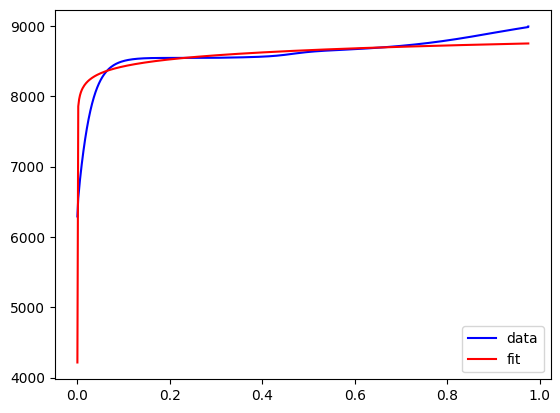

In [22]:
plt.plot(x, y, 'b-', label='data')
plt.plot(x, log_func(x, *popt), 'r-', label='fit')
plt.legend()
plt.show()

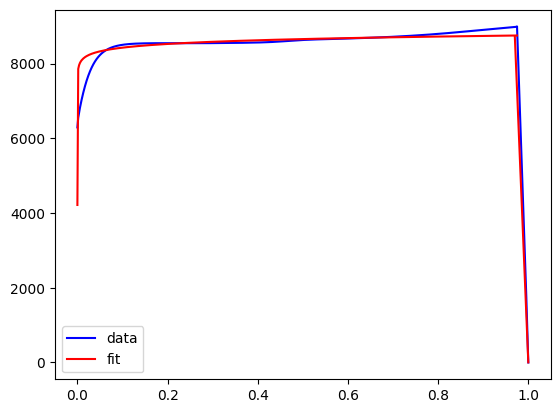

In [23]:
# to show the whole blue curve

x_2 = df_charging['SOC'].to_numpy()
y_2 = df_charging['pos_power'].to_numpy()

df_charging_partial_2 = df_charging.loc[np.arange(max_power_index.item() -4, df_charging.index[-1])]
x_3 = df_charging_partial_2['SOC'].to_numpy()
y_3 = -291845.5723 * x_3 + 291845.5723
# y_3 = -175107.3434 * x_3 + 175107.3434 # -15

plt.plot(x_2, y_2, 'b-', label='data')
plt.plot(x, log_func(x, *popt), 'r-', label='fit')
plt.plot(x_3, y_3, 'r-')
plt.legend()
plt.show()

### Dis-charging

### From df_dis_charging, construct a model with concave equation

In [24]:
from scipy.optimize import curve_fit

x_4 = df_dis_charging['SOC'].to_numpy()
y_4 = df_dis_charging['power'].to_numpy()

def log_func(x, a, b):
    return a*np.log(x) + b

popt, pcov = curve_fit(log_func, x_4, y_4)

popt[0], popt[1]

(306.3321681518971, 8838.798617471277)

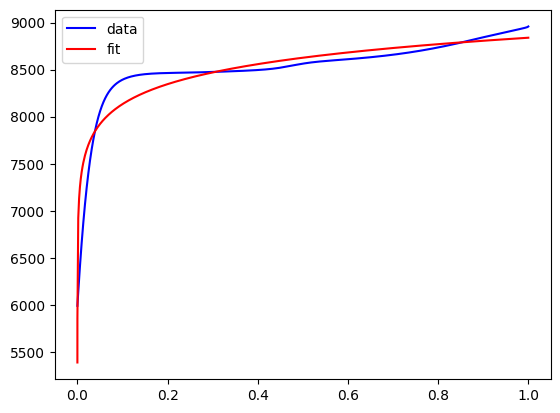

In [25]:
plt.plot(x_4, y_4, 'b-', label='data')
plt.plot(x_4, log_func(x_4, *popt), 'r-', label='fit')
plt.legend()
plt.show()

### Battery pack dis-charging power limit
$$ P(SOC) = 391.8398 log(SOC) + 11046.1139 $$

### Battery pack charging power limit
$$ P(SOC) = 193.6084 log(SOC) + 14586.9917 $$

### Total Capacity (unit: Ah)

4,416 pcs of 2170 cells:
- 46 cells in parallel (summing capacity) for each group
- 96 groups in series (summing voltage).

In [26]:
cell_model.total_capacity * 46

214.415404974919

In [27]:
# max voltage during the whole experiment
# including charging and discharging

max(df_pack['voltage'])

374.4000030440321

In [28]:
# max power during charging

min(df_pack['power'])

-8993.283314020819

In [29]:
# max power during dis-charging

max(df_pack['power'])

8958.256807787147